<a href="https://colab.research.google.com/github/Prashant997/Abstract_Classifier/blob/main/Abstract_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
import os

#### confirm access to gpu

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c580422b-b647-4943-be70-2c9aaa01f1cb)


## Getting the data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 37.68 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT/"

In [5]:
def read_file(filepath):
  with open(filepath, "r") as f:
    return f.readlines()

In [6]:
train_file = read_file(data_dir + "train.txt")
test_file = read_file(data_dir + "test.txt")
val_file = read_file(data_dir + "dev.txt")

#### Creating a function to convert the text into a dictionary

In [7]:
import re

def PubMed_todf(data):
  dict_list = []
  abst_id_curr = 0
  for i, sent in enumerate(data):
    sent_dict = {}
    if sent.startswith("###"):
      abst_id_curr = int(sent[3: ])
    elif "\t" in sent:
        sent_list = sent.split("\t")
        sent_dict["line_no"] = i
        sent_dict["abstract_id"] = abst_id_curr
        sent_dict["text"] = sent_list[1]
        sent_dict["target"] = sent_list[0]
        sent_dict["text"] = re.sub(r"[0-9]+", "@", sent_dict["text"])
        dict_list.append(sent_dict)

  abst_id_prev = dict_list[0]["abstract_id"]
  line_no = 0

  for d in dict_list:
    if abst_id_prev == d["abstract_id"]:
      line_no += 1
    else:
      abst_id_prev = d["abstract_id"]
      line_no = 1
    d["line_no"] = line_no

  return pd.DataFrame(dict_list)

In [8]:
train_df = PubMed_todf(train_file)
test_df = PubMed_todf(test_file)
val_df =  PubMed_todf(val_file)

## EDA

Text(0, 0.5, 'Percentage of abstracts')

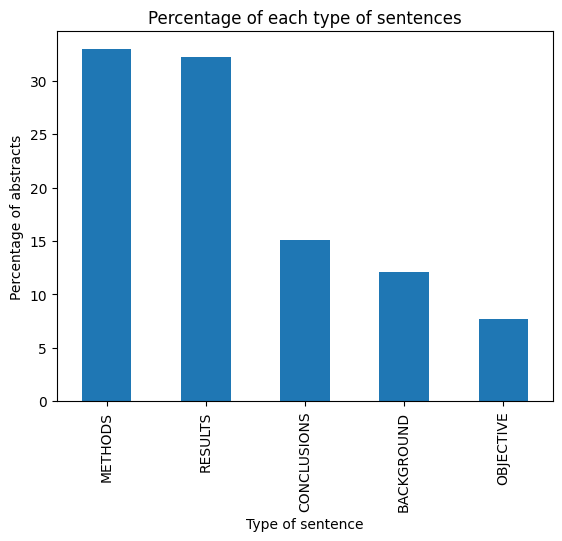

In [9]:
ax = (train_df["target"].value_counts()/len(train_df) * 100).plot(kind="bar")
ax.set_title("Percentage of each type of sentences")
ax.set_xlabel("Type of sentence")
ax.set_ylabel("Percentage of abstracts")

#### no. of sentences in each abstract

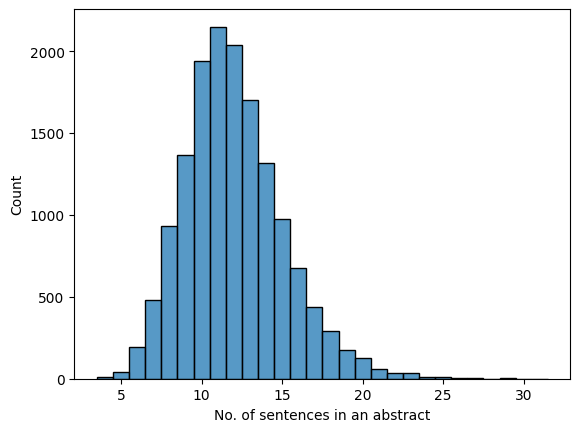

In [10]:
g = sns.histplot(train_df.abstract_id.value_counts(), discrete=True)
plt.xlabel("No. of sentences in an abstract")
plt.show(g)

<Axes: >

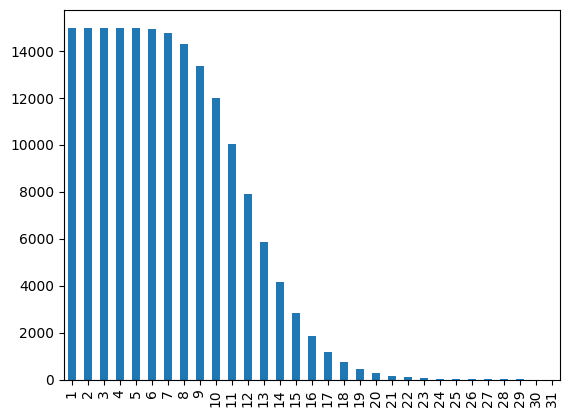

In [11]:
train_df.line_no.value_counts().plot(kind="bar")

#### sentence length

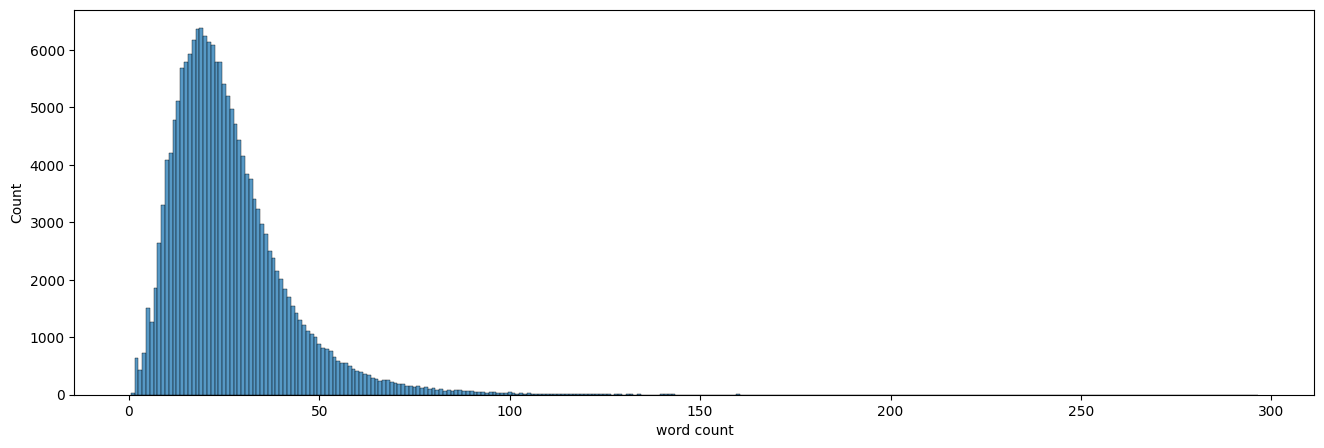

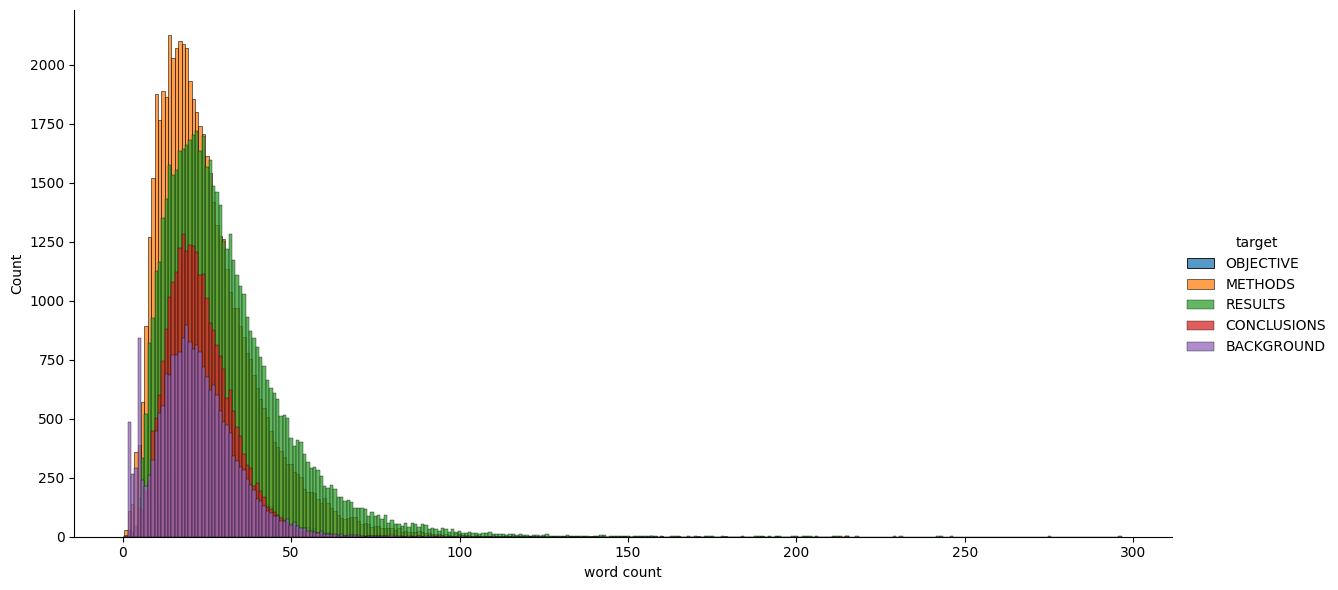


Average sentence length =  26.338435903132638
Median sentence length =  23.0
Max sentence length =  296


In [12]:
plt.subplots(figsize=(16, 5))
train_df["length"] = train_df.text.map(lambda x: len([word for word in str(x).split()]))
g = sns.histplot(train_df.length, discrete=True)
plt.xlabel("word count")
plt.show(g)
print()
g1 = sns.FacetGrid(train_df,
                   hue="target",
                   aspect=2,
                   height=6).map(sns.histplot,
                                 "length",
                                 discrete=True).add_legend()
plt.xlabel("word count")
plt.show(g1)
print()
print("Average sentence length = ", train_df.length.mean())
print("Median sentence length = ", train_df.length.median())
print("Max sentence length = ", train_df.length.max())


#### No. of characters in each sentence

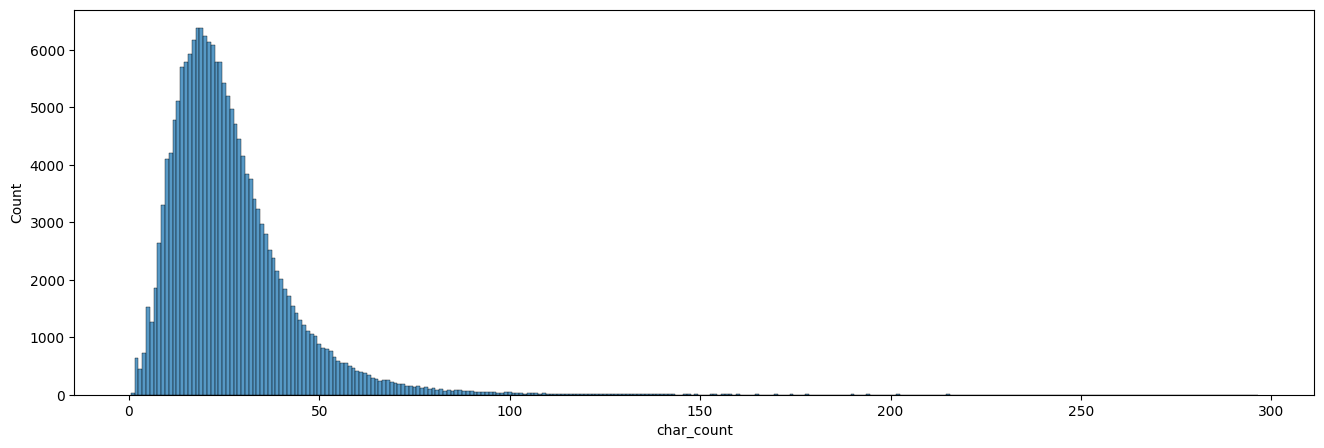

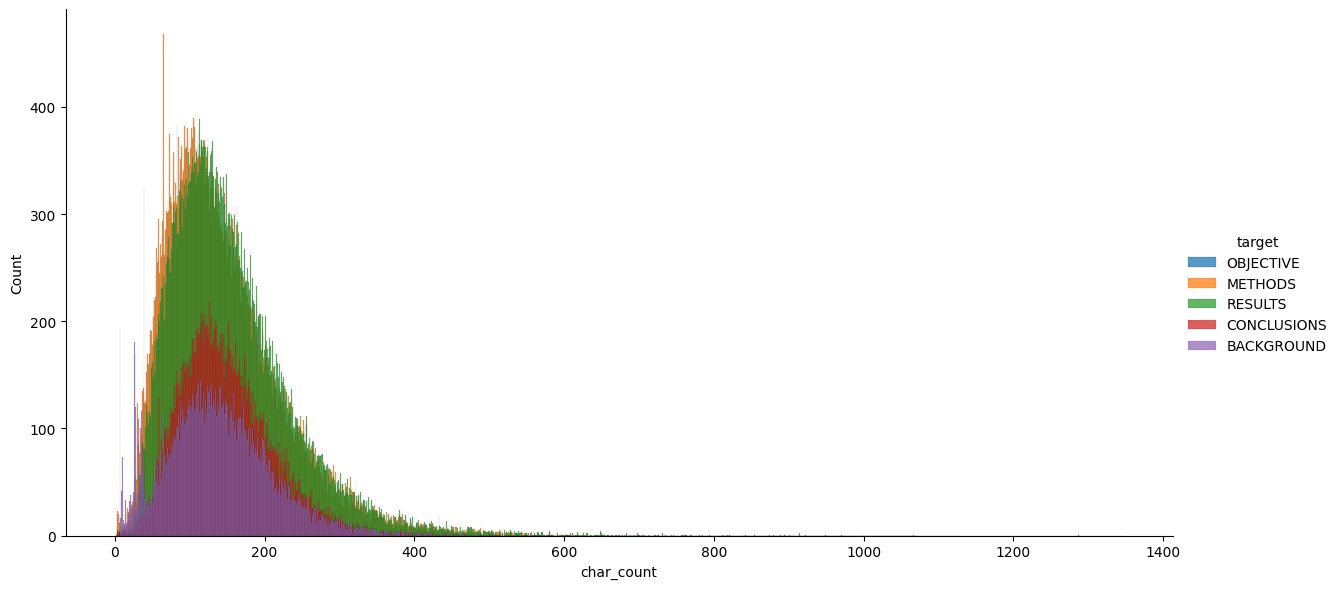


Average char count =  151.13710286602978
Median char count =  139.0
Max char count =  1345


In [13]:
plt.subplots(figsize=(16, 5))
train_df["char_count"] = train_df.text.map(lambda x: len(x))
g = sns.histplot(train_df.length, discrete=True)
plt.xlabel("char_count")
plt.show(g)
print()
g1 = sns.FacetGrid(train_df,
                   hue="target",
                   aspect=2,
                   height=6).map(sns.histplot,
                                 "char_count",
                                 discrete=True).add_legend()
plt.show(g1)
print()
print("Average char count = ", train_df.char_count.mean())
print("Median char count = ", train_df.char_count.median())
print("Max char count = ", train_df.char_count.max())

## Creating a model

#### Creating an evaluation function for the later models to use

In [14]:
from sklearn.metrics import confusion_matrix
def beautify_cm(ytrue, ypred, cls):
  g = sns.heatmap(confusion_matrix(ytrue, ypred),
                  annot=True,
                  fmt="d",
                  xticklabels=cls,
                  yticklabels=cls)
  plt.show(g)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(train_pred, val_pred, test_pred, ytr, yval, yte, cls):
  acc = [
      accuracy_score(ytr, train_pred),
      accuracy_score(yval, val_pred),
      accuracy_score(yte, test_pred)
  ]
  prec = [
      precision_score(ytr, train_pred, average="macro"),
      precision_score(yval, val_pred, average="macro"),
      precision_score(yte, test_pred, average="macro")
  ]
  recall = [
      recall_score(ytr, train_pred, average="macro"),
      recall_score(yval, val_pred, average="macro"),
      recall_score(yte, test_pred, average="macro")
  ]
  f = [
      f1_score(ytr, train_pred, average="macro"),
      f1_score(yval, val_pred, average="macro"),
      f1_score(yte, test_pred, average="macro")
  ]

  beautify_cm(ytr, train_pred, cls)
  beautify_cm(yval, val_pred, cls)
  beautify_cm(yte, test_pred, cls)

  fig = plt.figure()
  pd.DataFrame({
      "accuracy": acc,
      "precision": prec,
      "recall": recall,
      "f-score": f
  }, index=[
      "Training",
      "Validation",
      "Test"
  ]).plot(kind="bar", ax=fig.gca())
  plt.ylim(0, 1)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

### Preprocessing the data

#### one hot encode the labels

In [16]:
from sklearn.preprocessing import OneHotEncoder

def hot1_encode_labels(train_df, val_df, test_df):
  hot1 = OneHotEncoder(sparse=False)
  ytrain = hot1.fit_transform(train_df.target.values.reshape(-1, 1))
  yval = hot1.transform(val_df.target.values.reshape(-1, 1))
  ytest = hot1.transform(test_df.target.values.reshape(-1, 1))
  features = [f.split("_")[1] for f in hot1.get_feature_names_out()]
  return ytrain, yval, ytest, features

#### encode the labels using LabelEncoder

In [17]:
from sklearn.preprocessing import LabelEncoder

def encode_label(train_df, val_df, test_df):
  le = LabelEncoder()
  ytrain = le.fit_transform(train_df.target.values)
  yval = le.transform(val_df.target.values)
  ytest = le.transform(test_df.target.values)
  return ytrain, yval, ytest, le.classes_

### Baselines

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

#### MultinomialNB

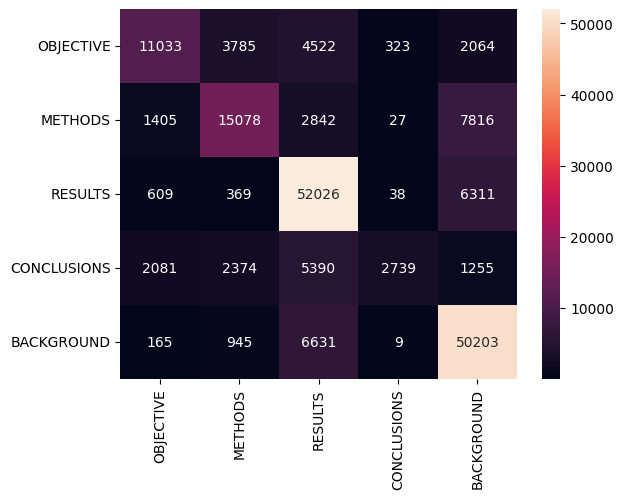

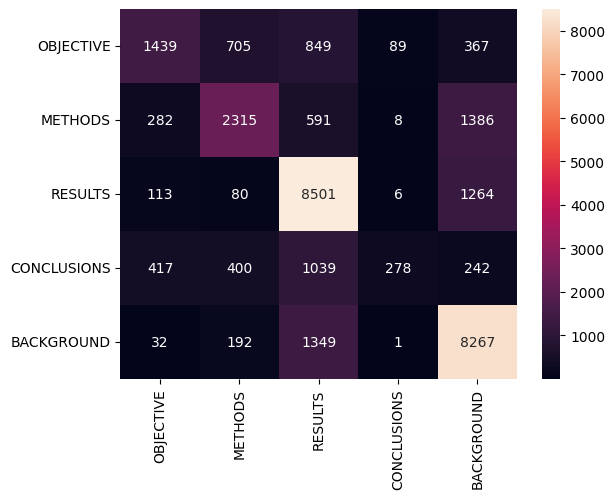

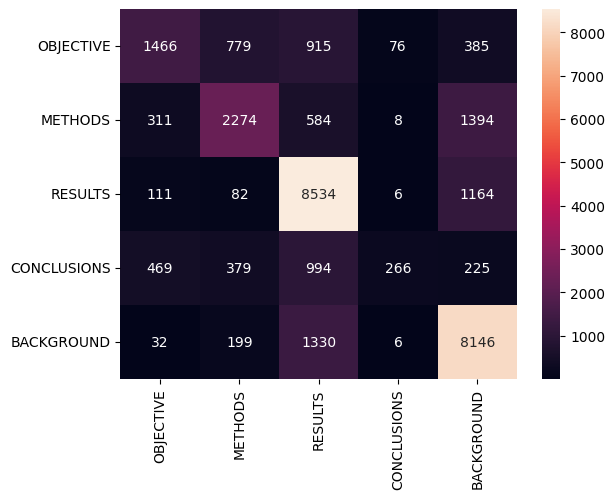

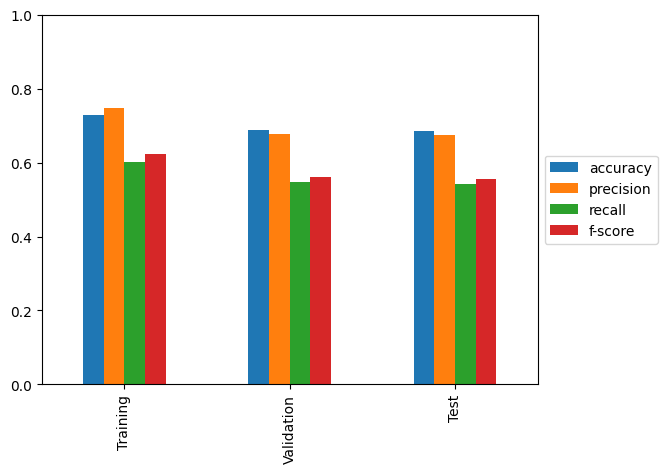

In [19]:
from sklearn.naive_bayes import MultinomialNB

ytr, yval, yte, cls = encode_label(train_df, val_df, test_df)
m_nb = Pipeline([
    ("TF-IDF", TfidfVectorizer(stop_words="english")),
    ("m_nb", MultinomialNB())
])

m_nb.fit(train_df.text.values, ytr)
evaluate(m_nb.predict(train_df.text),
         m_nb.predict(val_df.text),
         m_nb.predict(test_df.text),
         ytr, yval, yte, cls=train_df.target.unique())

#### Random Foest Classifier

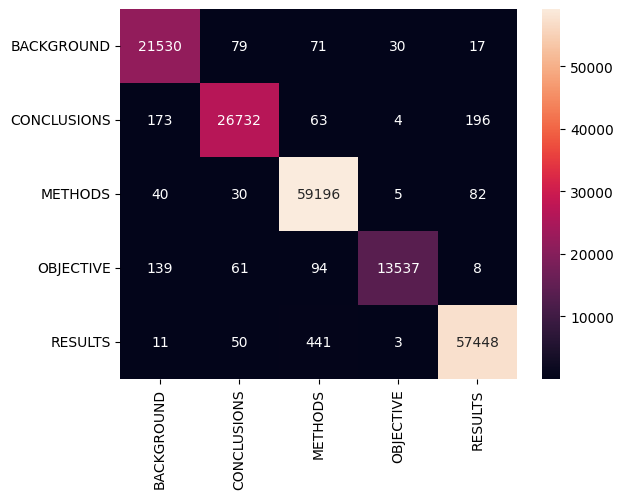

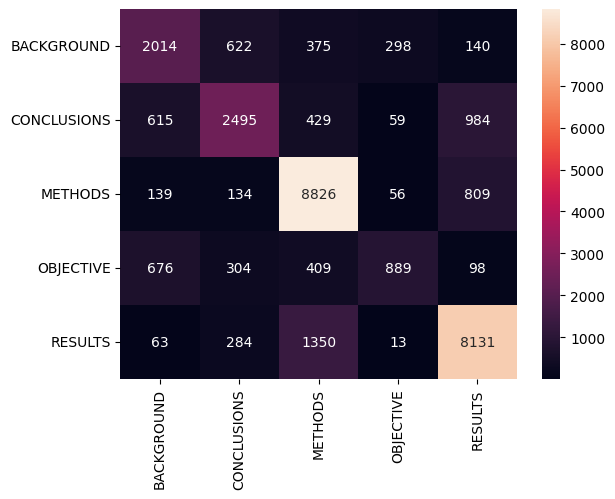

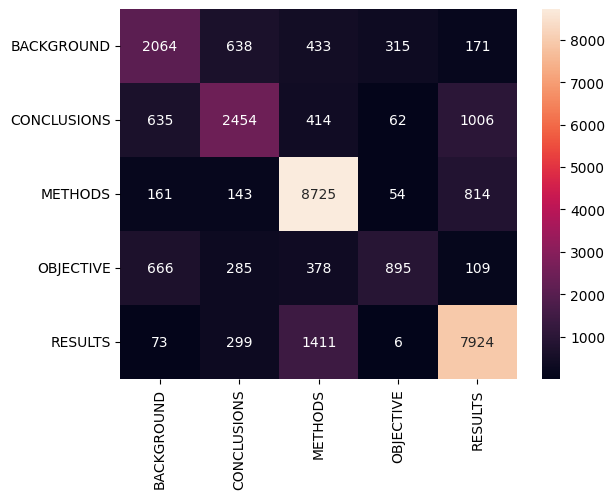

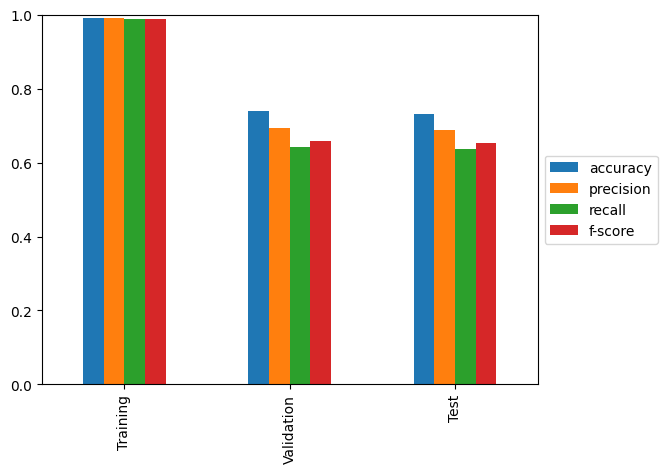

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfc = Pipeline([
    ("TF-IDF", TfidfVectorizer()),
    ("rfc", RandomForestClassifier(n_estimators=10))
])
rfc.fit(train_df.text.values, ytr)
evaluate(rfc.predict(train_df.text),
         rfc.predict(val_df.text),
         rfc.predict(test_df.text),
         ytr, yval, yte, cls)

### Using deep learning

conevrting an entire sentence of upto 300 words each into a vector can lose info.

so we will fix the sentences to a certain length.
1. those with length less than the fixed length will be padded on.
2. longer sentences will be truncated

the fixed length is set to 96 percentile.

Here we need to use one hot encoding to get proper results

In [21]:
ytr, yval, ytest, features = hot1_encode_labels(train_df, val_df, test_df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Creating a function to convert a one-hot encoded label into a human readable one

#### Creating the dataset using tf.data api, so that the data loads as fast as possible

tf.data can optimize the data fetching and training process by parallelizing the tasks performed.

in *Naive approach of loading a dataset*, the tasks run sequentially, one after the other, thus when one of the systems work, others remain idle. this increases the loading time, as seen in the image below:
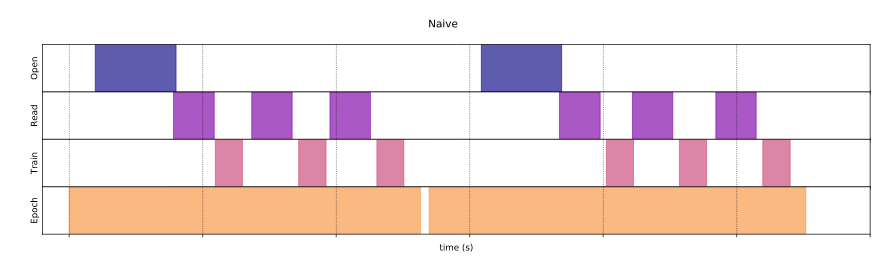

in prefetched dataset, reading and training goes on side by side.
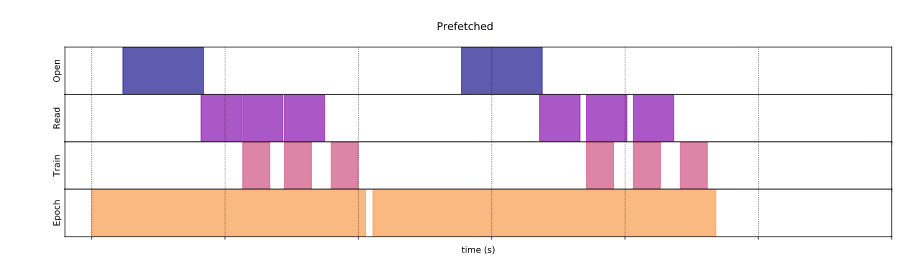

the other ways to speed up loading are present in https://www.tensorflow.org/guide/data_performance with examples and explanations.

In [22]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.text.values, ytr))
val_data = tf.data.Dataset.from_tensor_slices((val_df.text.values, yval))
test_data = tf.data.Dataset.from_tensor_slices((test_df.text.values, ytest))

#### Converting the dataset into a prefetched dataset

In [23]:
train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

#### Convolutional 1D model

##### using word

###### Creating a text vectorization layer

In [24]:
text_vec = layers.TextVectorization(max_tokens=65000,
                                    output_sequence_length=int(train_df.length.quantile(0.96)))
text_vec.adapt(train_df.text.values)

In [25]:
vocab_rct20k = text_vec.get_vocabulary()
print("Most common words: ", vocab_rct20k[: 5])
print("Rarest words: ", vocab_rct20k[-5: ])
print("vocab length = ", len(vocab_rct20k))

Most common words:  ['', '[UNK]', 'the', 'and', 'of']
Rarest words:  ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']
vocab length =  64839


###### Creating an embedding layer

In [26]:
embed = layers.Embedding(input_dim=len(vocab_rct20k),
                         output_dim=128,
                         mask_zero=True)
# masking reduces the computational time and space required if there are a lot of zeros in the vector

###### Creating the model

In [27]:
ips = layers.Input(shape=(1, ),
                  dtype="string")
var = text_vec(ips)
var = embed(var)
var = layers.Conv1D(64,
                    kernel_size=5,
                    padding="same",
                    activation="relu")(var)
var = layers.GlobalMaxPooling1D()(var)
ops = layers.Dense(5, activation="softmax")(var)
conv1d = tf.keras.Model(ips, ops)

conv1d.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
               metrics=["accuracy"])
conv1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 58)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 58, 128)           8299392   
                                                                 
 conv1d (Conv1D)             (None, 58, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [28]:
from tensorflow.keras.callbacks import LearningRateScheduler

sched = LearningRateScheduler(lambda e: 0.0005 * 10 ** e/10)
history = conv1d.fit(train_data,
                     epochs=5,
                     validation_data=val_data)

Epoch 1/5
5627/5627 [==============================] - 94s 15ms/step - loss: 0.5537 - accuracy: 0.7948 - val_loss: 0.5077 - val_accuracy: 0.8143
Epoch 2/5
5627/5627 [==============================] - 38s 7ms/step - loss: 0.3693 - accuracy: 0.8685 - val_loss: 0.5767 - val_accuracy: 0.8047
Epoch 3/5
5627/5627 [==============================] - 37s 7ms/step - loss: 0.2227 - accuracy: 0.9254 - val_loss: 0.7223 - val_accuracy: 0.7903
Epoch 4/5
5627/5627 [==============================] - 37s 7ms/step - loss: 0.1307 - accuracy: 0.9582 - val_loss: 0.9348 - val_accuracy: 0.7779
Epoch 5/5
5627/5627 [==============================] - 37s 7ms/step - loss: 0.0896 - accuracy: 0.9708 - val_loss: 1.1130 - val_accuracy: 0.7867


<Axes: >

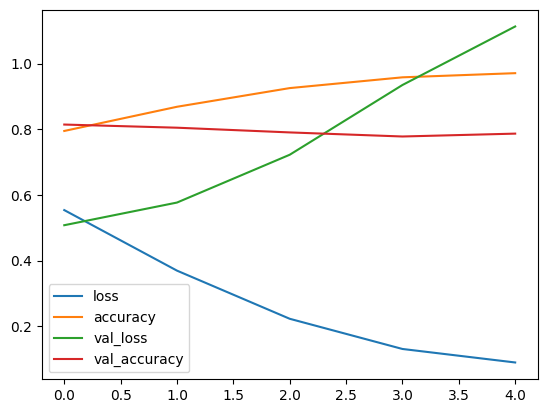

In [29]:
pd.DataFrame(history.history).plot()

In [30]:
conv1d.evaluate(test_df.text.values, ytest)

942/942 [==============================] - 3s 3ms/step - loss: 1.1682 - accuracy: 0.7777


[1.1681777238845825, 0.7777003645896912]

##### Using Characters

In [31]:
train_df_char = train_df.text.map(lambda x: " ".join([c for c in str(x)]))
test_df_char = test_df.text.map(lambda x: " ".join([c for c in str(x)]))
val_df_char = val_df.text.map(lambda x: " ".join([c for c in str(x)]))

###### create a char vectorizer

In [32]:
char_vec = layers.TextVectorization(output_sequence_length=int(train_df.char_count.quantile(0.95)))
char_vec.adapt(train_df_char.values)

In [33]:
vocab_rct20k_char = char_vec.get_vocabulary()
print("Vocab length = ", len(vocab_rct20k_char))
print("5 most common characters: ",vocab_rct20k_char[: 5])
print("5 rarest characters: ",vocab_rct20k_char[-5: ])

Vocab length =  28
5 most common characters:  ['', '[UNK]', 'e', 't', 'i']
5 rarest characters:  ['k', 'x', 'z', 'q', 'j']


###### Create an embedding layer

In [34]:
embed_char = layers.Embedding(input_dim=len(vocab_rct20k_char),
                              output_dim=25,
                              mask_zero=True)

###### Creating the model

In [35]:
ips = layers.Input(shape=(1,), dtype="string")
var = char_vec(ips)
var = embed_char(var)
var = layers.Conv1D(64,
                    kernel_size=5,
                    padding="same",
                    activation="relu")(var)
var = layers.GlobalMaxPooling1D()(var)
ops = layers.Dense(5, activation="softmax")(var)
conv1d_char = tf.keras.Model(ips, ops)

conv1d_char.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

conv1d_char.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 293)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 293, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 293, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [36]:
from tensorflow.keras.callbacks import LearningRateScheduler

sched = LearningRateScheduler(lambda e: 0.0008 * 10 ** e/10)
history = conv1d_char.fit(x=train_df_char.values, y=ytr,
                          epochs=8,
                          validation_data=(val_df_char, yval))

Epoch 1/8
5627/5627 [==============================] - 41s 7ms/step - loss: 0.9003 - accuracy: 0.6475 - val_loss: 0.7802 - val_accuracy: 0.7006
Epoch 2/8
5627/5627 [==============================] - 39s 7ms/step - loss: 0.7520 - accuracy: 0.7136 - val_loss: 0.7528 - val_accuracy: 0.7171
Epoch 3/8
5627/5627 [==============================] - 41s 7ms/step - loss: 0.7166 - accuracy: 0.7278 - val_loss: 0.6967 - val_accuracy: 0.7375
Epoch 4/8
5627/5627 [==============================] - 40s 7ms/step - loss: 0.6972 - accuracy: 0.7366 - val_loss: 0.6887 - val_accuracy: 0.7406
Epoch 5/8
5627/5627 [==============================] - 41s 7ms/step - loss: 0.6843 - accuracy: 0.7417 - val_loss: 0.6784 - val_accuracy: 0.7424
Epoch 6/8
5627/5627 [==============================] - 43s 8ms/step - loss: 0.6742 - accuracy: 0.7458 - val_loss: 0.6917 - val_accuracy: 0.7397
Epoch 7/8
5627/5627 [==============================] - 40s 7ms/step - loss: 0.6667 - accuracy: 0.7508 - val_loss: 0.6659 - val_accuracy:

#### Creating a model with universal sentence encoder

##### download use model and create an embeddinng layer



In [37]:
import tensorflow_hub as hub
embed_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                             trainable=False,
                             name="use")

##### Creating the model

In [38]:
ips = layers.Input(shape=[], dtype=tf.string)
var = embed_layer(ips)
var = layers.Dense(128, activation="relu")(var)
ops = layers.Dense(5, activation="softmax")(var)

use = tf.keras.Model(ips, ops)
use.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"])
use.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 use (KerasLayer)            (None, 512)               147354880 
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 147,421,189
Trainable params: 66,309
Non-trainable params: 147,354,880
_________________________________________________________________


In [39]:
history = use.fit(train_data,
                  epochs=5,
                  validation_data=val_data)

Epoch 1/5
5627/5627 [==============================] - 379s 63ms/step - loss: 0.6291 - accuracy: 0.7640 - val_loss: 0.5556 - val_accuracy: 0.7892
Epoch 2/5
5627/5627 [==============================] - 344s 61ms/step - loss: 0.5374 - accuracy: 0.7995 - val_loss: 0.5216 - val_accuracy: 0.8032
Epoch 3/5
5627/5627 [==============================] - 344s 61ms/step - loss: 0.5060 - accuracy: 0.8114 - val_loss: 0.5072 - val_accuracy: 0.8094
Epoch 4/5
5627/5627 [==============================] - 346s 61ms/step - loss: 0.4847 - accuracy: 0.8199 - val_loss: 0.5002 - val_accuracy: 0.8145
Epoch 5/5
5627/5627 [==============================] - 350s 62ms/step - loss: 0.4678 - accuracy: 0.8269 - val_loss: 0.4969 - val_accuracy: 0.8145


#### Creating a model with char and word embedding concatenated.


##### word embedding model using universal sentence encoder (USE)

In [40]:
ips_word = layers.Input(shape=[], dtype="string")
var_word = embed_layer(ips_word)
ops_word_embed = layers.Dense(128, activation="softmax")(var_word)
word_embed = tf.keras.Model(inputs=ips_word,
                            outputs=ops_word_embed,
                            name="word embedding model (USE)")

##### bi-directional model for character embeddings

In [41]:
# character embedding model
ips_char = layers.Input(shape=(1, ), dtype="string")
var_char = char_vec(ips_char)
ops_char_embed = embed_char(var_char)
# the paper used 300 neurons, but here we are usig 128 neurons

# bi-directional lstm model for the character embedding
lstm = layers.Bidirectional(layers.LSTM(24))(ops_char_embed)  # as in the paper
char_bi_lstm = tf.keras.Model(inputs=ips_char,
                              outputs=lstm,
                              name="char_bidirectional-lstm")

##### Concatenating word embedding and character bi-lstm models to create a hybrid token embedding layer

In [42]:
embed_hybrid = layers.Concatenate(name="hybrid_embedding")([word_embed.output,
                                                            char_bi_lstm.output])

##### Creating a bi-lstm model for hybrid token embedding created

In [43]:
var = layers.Dense(128, activation="relu")(embed_hybrid)
dropout = layers.Dropout(0.5)(var)
output_layer = layers.Dense(5, activation="softmax")(dropout)

##### Creating a model

In [44]:
bi_hybrid = tf.keras.Model(inputs=[word_embed.inputs,
                                   char_bi_lstm.inputs],
                           outputs=output_layer)

bi_hybrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
bi_hybrid.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 293)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 use (KerasLayer)               (None, 512)          147354880   ['input_4[0][0]']          

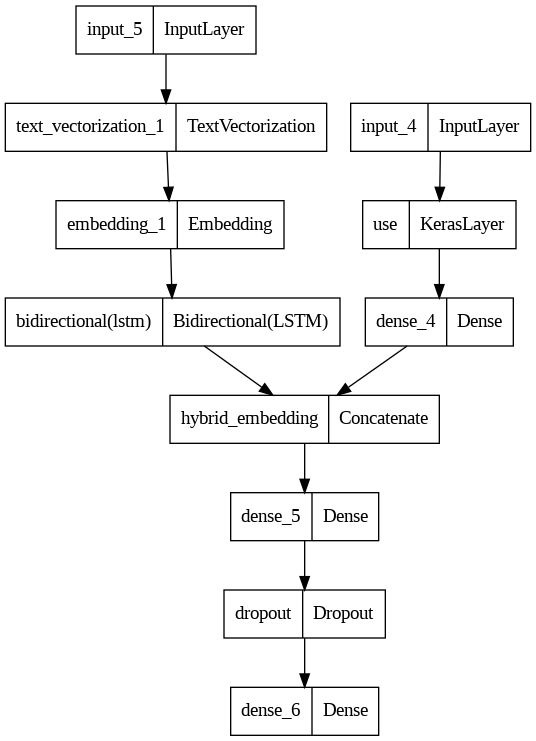

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(bi_hybrid)

##### Preparing the dataset for fitting

In [46]:
# Concatenate the word tokens and the characters
def create_data_for_concat_model(word_df, char_df, label):
  word_char = tf.data.Dataset.from_tensor_slices((word_df, char_df))
  label_sped_up = tf.data.Dataset.from_tensor_slices(label)
  data = tf.data.Dataset.zip((word_char, label_sped_up))

  return data.batch(32).prefetch(tf.data.AUTOTUNE)

train_data = create_data_for_concat_model(train_df.text.values,
                                          train_df_char,
                                          ytr)
val_data = create_data_for_concat_model(val_df.text.values,
                                        val_df_char,
                                        yval)
test_data =create_data_for_concat_model(test_df.text.values,
                                        test_df_char,
                                        ytest)

##### Fitting the model

In [47]:
from tensorflow.keras.callbacks import LearningRateScheduler

sched = LearningRateScheduler(lambda e: 0.0008 * 10 ** e/10)
bi_hybrid.fit(train_data,
              steps_per_epoch=0.08 * len(train_data),
              epochs=5,
              validation_data=val_data,
              validation_steps=0.08 * len(val_data))

Epoch 1/5
450/450 [==============================] - 76s 122ms/step - loss: 1.2771 - accuracy: 0.4694 - val_loss: 0.9291 - val_accuracy: 0.6402
Epoch 2/5
450/450 [==============================] - 44s 97ms/step - loss: 0.8250 - accuracy: 0.6768 - val_loss: 0.7661 - val_accuracy: 0.6978
Epoch 3/5
450/450 [==============================] - 43s 95ms/step - loss: 0.7589 - accuracy: 0.7018 - val_loss: 0.7272 - val_accuracy: 0.7101
Epoch 4/5
450/450 [==============================] - 43s 96ms/step - loss: 0.7253 - accuracy: 0.7230 - val_loss: 0.6941 - val_accuracy: 0.7257
Epoch 5/5
450/450 [==============================] - 48s 106ms/step - loss: 0.6822 - accuracy: 0.7375 - val_loss: 0.6772 - val_accuracy: 0.7270


In [48]:
bi_hybrid.evaluate(test_data)

942/942 [==============================] - 61s 65ms/step - loss: 0.6675 - accuracy: 0.7437


[0.6674653887748718, 0.7436535358428955]

#### Creating a tribrid model with word, char and positional embedding

##### word embedding

In [49]:
ips_word = layers.Input(shape=[], dtype="string")
var_word = embed_layer(ips_word)
ops_word_embed = layers.Dense(128, activation="softmax")(var_word)
word_embed = tf.keras.Model(inputs=ips_word,
                            outputs=ops_word_embed,
                            name="word embedding model_tri (USE)")

##### char-embedding

In [50]:
ips_char = layers.Input(shape=(1,), dtype="string")
var_char = char_vec(ips_char)
ops_char_embed = embed_char(var_char)

lstm_ops = layers.Bidirectional(layers.LSTM(24))(ops_char_embed)
char_embed = tf.keras.Model(inputs=ips_char,
                              outputs=lstm_ops,
                              name="character_bi-lstm_layer")

##### Positional embedding

In [51]:
# one hot encoding the line number
max_pos = int(train_df.line_no.quantile(0.98))
train_line_pos = tf.one_hot(train_df.line_no, depth=max_pos)
val_line_pos = tf.one_hot(val_df.line_no, depth=max_pos)
test_line_pos = tf.one_hot(test_df.line_no, depth=max_pos)

In [52]:
ips_pos = layers.Input(shape=(max_pos, ))
ops_pos = layers.Dense(32, activation="relu")(ips_pos)

pos_embed = tf.keras.Model(inputs=ips_pos,
                     outputs=ops_pos,
                     name="postional embedding model")

##### Total lines embedding

In [53]:
# calculating the total number of lines in each abstract
def count_lines_abs(df):
  tot_lines = df[["abstract_id", "line_no"]].groupby("abstract_id", as_index=False).count()
  return df.merge(tot_lines, on="abstract_id").rename(mapper={
                                                    "line_no_y": "tot_lines",
                                                    "line_no_x": "line_no"
                                                    }, axis="columns")
train_df = count_lines_abs(train_df)
val_df = count_lines_abs(val_df)
test_df = count_lines_abs(test_df)

In [54]:
# one hot encoding the total number of lines in an abstract
max_lines_allowed = int(train_df.tot_lines.quantile(0.98))
train_line_tot = tf.one_hot(train_df.tot_lines, depth=max_lines_allowed)
val_line_tot = tf.one_hot(val_df.tot_lines, depth=max_lines_allowed)
test_line_tot = tf.one_hot(test_df.tot_lines, depth=max_lines_allowed)

In [55]:
# creating the model

ips_tot = layers.Input(shape=(max_lines_allowed, ))
ops_tot = layers.Dense(32, activation="relu")(ips_tot)
tot_embed = tf.keras.Model(inputs=ips_tot,
                     outputs=ops_tot,
                     name="abstract total lines model")

##### Concatenation

In [56]:
# Concatenate word and char embeddings
embed_intermediate1 = layers.Concatenate(name="intermediate_embedding")([
    word_embed.output,
    char_embed.output
])

In [57]:
# Passing the combined word and char embeddings through a dense layer, then a dropout layer, as specified in the paper
embed_intermediate2 = layers.Dense(256, activation="relu")(embed_intermediate1)
embed_intermediate2 = layers.Dropout(0.5)(embed_intermediate2)


In [58]:
# Concatenate positional and total lines embeddings
embed_final = layers.Concatenate(name="combined_embedding")([
    embed_intermediate2,
    pos_embed.output,
    tot_embed.output
])

##### Creating the output layer



In [59]:
ops_tribrid = layers.Dense(5,activation="softmax")(embed_final)

##### Putting all the layers together

In [60]:
tribrid = tf.keras.Model(inputs=[
    word_embed.input,
    char_embed.input,
    pos_embed.input,
    tot_embed.input
], outputs=ops_tribrid,
name="word_char_positional_embedding_model")

In [61]:
tribrid.summary()

Model: "word_char_positional_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 293)         0           ['input_7[0][0]']                
 orization)                                                                                       
                                                                                                  
 use (KerasLayer)               (None, 512)          147354880 

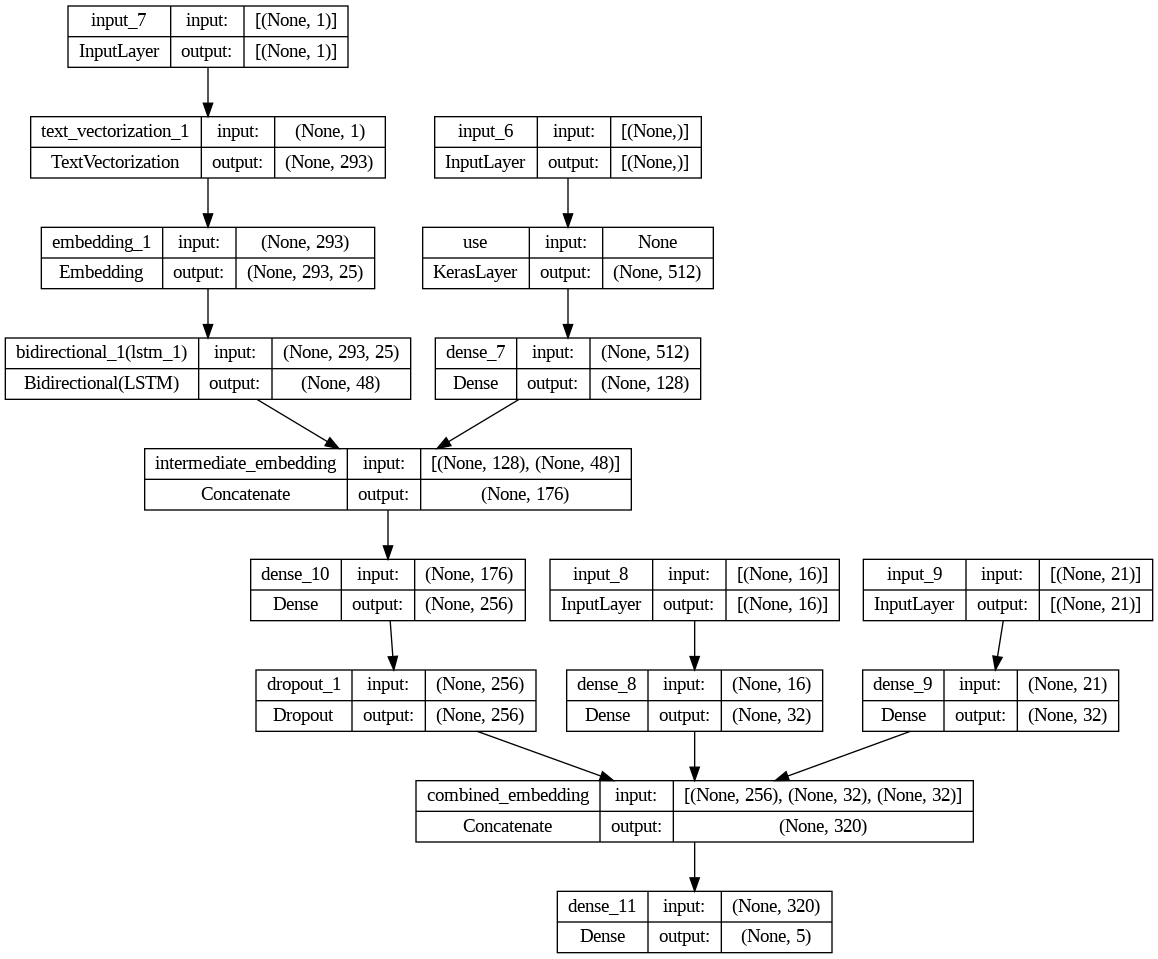

In [62]:
from keras.utils import plot_model

plot_model(tribrid, show_shapes=True)

##### Compiling the model

In [63]:
tribrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

##### Creating the dataset to use for the tribrid model

In [64]:
def create_for_tribrid(df, df_char,df_pos, df_tot, lbl):
  df_tribrid = tf.data.Dataset.from_tensor_slices((df, df_char,
                                                   df_pos, df_tot))
  lbl = tf.data.Dataset.from_tensor_slices(lbl)
  df_tribrid = tf.data.Dataset.zip((df_tribrid, lbl))
  return df_tribrid.batch(32).prefetch(tf.data.AUTOTUNE)

tribrid_train_data = create_for_tribrid(train_df.text.values,
                                        train_df_char,
                                        train_line_pos,
                                        train_line_tot,
                                        ytr)
tribrid_test_data = create_for_tribrid(test_df.text.values,
                                      test_df_char,
                                      test_line_pos,
                                      test_line_tot,
                                      ytest)
tribrid_val_data = create_for_tribrid(val_df.text.values,
                                      val_df_char,
                                      val_line_pos,
                                      val_line_tot,
                                      yval)

##### Fitting the model

In [65]:
tribrid.fit(tribrid_train_data,
            epochs=5,
            steps_per_epoch=0.15*len(tribrid_train_data),
            validation_data=tribrid_val_data)

Epoch 1/5
844/844 [==============================] - 161s 167ms/step - loss: 0.8309 - accuracy: 0.6739 - val_loss: 0.5077 - val_accuracy: 0.8078
Epoch 2/5
844/844 [==============================] - 128s 152ms/step - loss: 0.4838 - accuracy: 0.8132 - val_loss: 0.4480 - val_accuracy: 0.8231
Epoch 3/5
844/844 [==============================] - 134s 158ms/step - loss: 0.4456 - accuracy: 0.8323 - val_loss: 0.4139 - val_accuracy: 0.8423
Epoch 4/5
844/844 [==============================] - 129s 153ms/step - loss: 0.4295 - accuracy: 0.8342 - val_loss: 0.3938 - val_accuracy: 0.8493
Epoch 5/5
844/844 [==============================] - 134s 159ms/step - loss: 0.4066 - accuracy: 0.8445 - val_loss: 0.3870 - val_accuracy: 0.8522


##### Evaluating the model on various datasets

In [66]:
tribrid.evaluate(tribrid_test_data)

942/942 [==============================] - 59s 63ms/step - loss: 0.4055 - accuracy: 0.8501


[0.4054507315158844, 0.8501078486442566]

In [67]:
test200k = PubMed_todf(read_file("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt"))
test200k_char = test200k.text.map(lambda x: " ".join([c for c in str(x).split()]))
test200k = count_lines_abs(test200k)
test200k_line_pos = tf.one_hot(test200k.line_no, depth=max_pos)
test200k_tot = tf.one_hot(test200k.tot_lines, depth=max_lines_allowed)

hot1 = OneHotEncoder(sparse=False)
y = hot1.fit_transform(test200k.target.values.reshape(-1, 1))

test200k_data = create_for_tribrid(test200k.text.values,
                                   test200k_char,
                                   test200k_line_pos,
                                   test200k_tot,
                                   y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [68]:
tribrid.evaluate(test200k_data)

905/905 [==============================] - 54s 59ms/step - loss: 0.4198 - accuracy: 0.8173


[0.4197925627231598, 0.8172611594200134]

## Saving the tribrid model

As the tribrid model is the best performing model, we will save this model.

In [69]:
tribrid.save("final_model")